<a href="https://colab.research.google.com/github/natihbernan/sentimentanalysis/blob/master/Sentiment_Analysis_Shopee_Code_League.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis using Long Short Term Memory (LSTM)

This notebook contains the code of our team project on Shopee Code League Sentiment Analysis

---

Team: "Ganteng" Organization

### Import the Data

We import the dataset used in this project from Kaggle into Colab environment. After that we extract the data since it is in .zip format.

In [1]:
# Colab library to upload files to notebook
from google.colab import files

# Install Kaggle library
#!pip install -q kaggle
!pip uninstall -y kaggle
!pip install --upgrade pip
!pip install kaggle==1.5.6

Uninstalling kaggle-1.5.6:
  Successfully uninstalled kaggle-1.5.6
     |████████████████████████████████| 1.5MB 4.9MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1
     |████████████████████████████████| 58 kB 2.3 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.6-py3-none-any.whl size=72859 sha256=07792a14adc7cc5ecf883b9e082374b8dc2e4b8c2b18e4f150bc674581422b25
  Stored in directory: /root/.cache/pip/wheels/01/3e/ff/77407ebac3ef71a79b9166a8382aecf88415a0bcbe3c095a01
Successfully built kaggle


In [2]:
# Upload kaggle API key file
data = files.upload()

Saving kaggle.json to kaggle.json


In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
# Download the dataset from kaggle
!kaggle competitions download -c shopee-sentiment-analysis

 71% 5.00M/7.00M [00:00<00:00, 36.1MB/s]
100% 7.00M/7.00M [00:00<00:00, 48.6MB/s]


In [5]:
# Extract zipfile
import zipfile
zip_ref = zipfile.ZipFile('/content/shopee-sentiment-analysis.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

### Load Modules

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.models import Sequential
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

Using TensorFlow backend.


### Read Dataset

In [7]:
train_and_val = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')

In [8]:
train_and_val.head()

,review_id,review,rating
0,0,Ga disappointed neat products .. Meletot Hilsn...,1
1,1,"Rdtanya replace broken glass, broken chargernya",1
2,2,Nyesel bngt dsni shopping antecedent photo mes...,1
3,3,Sent a light blue suit goods ga want a refund,1
4,4,Pendants came with dents and scratches on its ...,1


In [9]:
test.head()

,review_id,review
0,1,"Great danger, cool, motif and cantik2 jg model..."
1,2,One of the shades don't fit well
2,3,Very comfortable
3,4,Fast delivery. Product expiry is on Dec 2022. ...
4,5,it's sooooo cute! i like playing with the glit...


In [10]:
train_and_val.rating.value_counts()

4    41865
5    41515
3    35941
1    14785
2    12705
Name: rating, dtype: int64

### Data Preprocessing

We can see that the class distribution is imbalanced, that is the number of samples belong to each class is significantly different. This could lead to a bad classification performance.

To overcome this problem, we will make the dataset more balanced by simply removing some of the samples so that every class has the same number of samples. This technique is known as **undersampling**

In [11]:
num_of_samples = 12000
shuffled = train_and_val.reindex(np.random.permutation(train_and_val.index))
rating_1 = shuffled[shuffled['rating'] == 1][:num_of_samples]
rating_2 = shuffled[shuffled['rating'] == 2][:num_of_samples]
rating_3 = shuffled[shuffled['rating'] == 3][:num_of_samples]
rating_4 = shuffled[shuffled['rating'] == 4][:num_of_samples]
rating_5 = shuffled[shuffled['rating'] == 5][:num_of_samples]
concated = pd.concat([rating_1, rating_2, rating_3, rating_4, rating_5], ignore_index=True)
#Shuffle the dataset
concated = concated.reindex(np.random.permutation(concated.index))
concated['label'] = 0
concated.rating.value_counts()

5    12000
4    12000
3    12000
2    12000
1    12000
Name: rating, dtype: int64

Next, we will do **One Hot Encoding** so the label can be understood easier by the machine. In order to do this, we need to create a new column called *label*, where the value of *rating* is changed from 1 until 5 to 0 until 4

In [12]:
concated.loc[concated['rating'] == 1, 'label'] = 0
concated.loc[concated['rating'] == 2, 'label'] = 1
concated.loc[concated['rating'] == 3, 'label'] = 2
concated.loc[concated['rating'] == 4, 'label'] = 3
concated.loc[concated['rating'] == 5, 'label'] = 4

labels = to_categorical(concated['label'], num_classes=5)
print(labels[:10])

'''
 [1. 0. 0. 0. 0.] 1
 [0. 1. 0. 0. 0.] 2
 [0. 0. 1. 0. 0.] 3
 [0. 0. 0. 1. 0.] 4
 [0. 0. 0. 0. 1.] 5
'''

[[0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]]


'\n [1. 0. 0. 0. 0.] 1\n [0. 1. 0. 0. 0.] 2\n [0. 0. 1. 0. 0.] 3\n [0. 0. 0. 1. 0.] 4\n [0. 0. 0. 0. 1.] 5\n'

### Tokenizing

In [13]:
n_most_common_words = 8000
max_len = 130
tokenizer = Tokenizer(num_words=n_most_common_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(concated['review'].values)
sequences = tokenizer.texts_to_sequences(concated['review'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

X = pad_sequences(sequences, maxlen=max_len)

Found 41766 unique tokens.


### Train and Validation Split

In [14]:
X_train, X_val, y_train, y_val = train_test_split(X , labels, test_size=0.2, random_state=42)

In [15]:
epochs = 10
emb_dim = 128
batch_size = 256

### Model Training

In [17]:
print((X_train.shape, y_train.shape, X_val.shape, y_val.shape))

model = Sequential()
model.add(Embedding(n_most_common_words, emb_dim, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.7))
model.add(LSTM(64, dropout=0.7, recurrent_dropout=0.7))
model.add(Dense(5, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
print(model.summary())
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2)

((48000, 130), (48000, 5), (12000, 130), (12000, 5))
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 130, 128)          1024000   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 130, 128)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 325       
Total params: 1,073,733
Trainable params: 1,073,733
Non-trainable params: 0
_________________________________________________________________
None


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 38400 samples, validate on 9600 samples
Epoch 1/10
38400/38400 [==============================] - 85s 2ms/step - loss: 1.5445 - acc: 0.2904 - val_loss: 1.3571 - val_acc: 0.4009
Epoch 2/10
38400/38400 [==============================] - 85s 2ms/step - loss: 1.3120 - acc: 0.4157 - val_loss: 1.1992 - val_acc: 0.4568
Epoch 3/10
38400/38400 [==============================] - 84s 2ms/step - loss: 1.2311 - acc: 0.4490 - val_loss: 1.1624 - val_acc: 0.4653
Epoch 4/10
38400/38400 [==============================] - 84s 2ms/step - loss: 1.1941 - acc: 0.4657 - val_loss: 1.1506 - val_acc: 0.4750
Epoch 5/10
38400/38400 [==============================] - 84s 2ms/step - loss: 1.1654 - acc: 0.4774 - val_loss: 1.1337 - val_acc: 0.4810
Epoch 6/10
38400/38400 [==============================] - 84s 2ms/step - loss: 1.1444 - acc: 0.4871 - val_loss: 1.1257 - val_acc: 0.4837
Epoch 7/10
38400/38400 [==============================] - 84s 2ms/step - loss: 1.1210 - acc: 0.4985 - val_loss: 1.1176 - val_acc:

### Learning History Plot

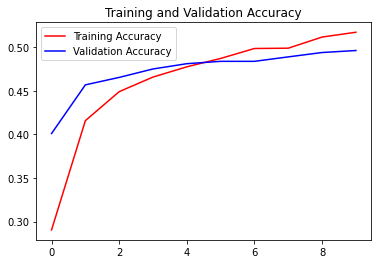

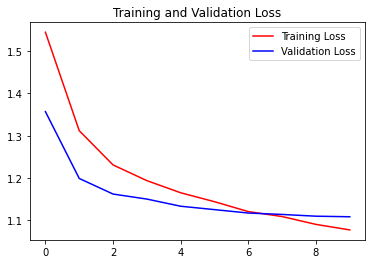

In [18]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label = 'Training Accuracy')
plt.plot(epochs, val_acc, 'b', label = 'Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc = 'best')
plt.show()

plt.plot(epochs, loss, 'r', label = 'Training Loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.legend(loc = 'best')
plt.show()

In [19]:
accr = model.evaluate(X_val,y_val)
print('Validation set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

12000/12000 [==============================] - 8s 657us/step
Validation set
  Loss: 1.108
  Accuracy: 0.496


We can see that the model still suffer with underfitting, which is the accuracy still poor, but we will leave it like that for now.

Next, we will try to insert some review sample and try to predict the rating

In [33]:
print('Insert review')
txt = [input()]
seq = tokenizer.texts_to_sequences(txt)
padded = pad_sequences(seq, maxlen=max_len)
pred = model.predict(padded)
labels = [1, 2, 3, 4, 5]
print(pred, '\nPredicted rating =', labels[np.argmax(pred)])

Insert review
This product is great and works perfectly!
[[0.00269103 0.015967   0.07679498 0.4297764  0.4747706 ]] 
Predicted rating = 5


### Create submission file

In [43]:
submission = pd.DataFrame(data = test.review_id)
submission['rating'] = 0
submission

,review_id,rating
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
...,...,...
60422,60423,0
60423,60424,0
60424,60425,0
60425,60426,0


In [61]:
for i in range(len(test)):
  txt = [test.review[i]]
  seq = tokenizer.texts_to_sequences(txt)
  padded = pad_sequences(seq, maxlen=max_len)
  pred = model.predict(padded)
  labels = [1, 2, 3, 4, 5]
  submission.rating[i] = labels[np.argmax(pred)]
  
submission.head()

,review_id,rating
0,1,3
1,2,2
2,3,5
3,4,1
4,5,4


In [62]:
submission.to_csv(r'/content/submission.csv', index = False)

### References

https://www.kaggle.com/ngyptr/multi-class-classification-with-lstm